#                                        2019 ACCIDENT DATA ANALYSIS
        
    

In [1]:
#Import Libraries to be used
import pandas as pd
import numpy as np
import pandas_profiling as pp
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import missingno as mn
import datetime
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from sklearn.cluster import KMeans
from functools import reduce
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2, f_regression, f_classif, RFE
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline
from imblearn.base import BaseSampler
from imblearn.over_sampling import (SMOTE, RandomOverSampler)
import imblearn
import networkx as nx
from imblearn.over_sampling import SMOTE
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import *
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean
from numpy import std
from numpy import hstack
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings ('ignore')
%matplotlib inline

In [2]:
#shows the full length of the columns
pd.set_option('display.max_columns', None)

In [3]:
#Import the three files
accidents = pd.read_csv ('Road Safety Data - Accidents 2019.csv')
casualties = pd.read_csv ('Road Safety Data - Casualties 2019.csv')
vehicles = pd.read_csv ('Road Safety Data- Vehicles 2019.csv')
govt_model = pd.read_csv ('cas_adjustment_lookup_2019.csv')

Check for null values

In [4]:
accidents.isnull().sum()

Accident_Index                                    0
Location_Easting_OSGR                            28
Location_Northing_OSGR                           28
Longitude                                        28
Latitude                                         28
Police_Force                                      0
Accident_Severity                                 0
Number_of_Vehicles                                0
Number_of_Casualties                              0
Date                                              0
Day_of_Week                                       0
Time                                             63
Local_Authority_(District)                        0
Local_Authority_(Highway)                         0
1st_Road_Class                                    0
1st_Road_Number                                   0
Road_Type                                         0
Speed_limit                                       0
Junction_Detail                                   0
Junction_Con

In [5]:
casualties.isnull().sum()

Accident_Index                        0
Vehicle_Reference                     0
Casualty_Reference                    0
Casualty_Class                        0
Sex_of_Casualty                       0
Age_of_Casualty                       0
Age_Band_of_Casualty                  0
Casualty_Severity                     0
Pedestrian_Location                   0
Pedestrian_Movement                   0
Car_Passenger                         0
Bus_or_Coach_Passenger                0
Pedestrian_Road_Maintenance_Worker    0
Casualty_Type                         0
Casualty_Home_Area_Type               0
Casualty_IMD_Decile                   0
dtype: int64

In [6]:
vehicles.isnull().sum()

Accident_Index                      0
Vehicle_Reference                   0
Vehicle_Type                        0
Towing_and_Articulation             0
Vehicle_Manoeuvre                   0
Vehicle_Location-Restricted_Lane    0
Junction_Location                   0
Skidding_and_Overturning            0
Hit_Object_in_Carriageway           0
Vehicle_Leaving_Carriageway         0
Hit_Object_off_Carriageway          0
1st_Point_of_Impact                 0
Was_Vehicle_Left_Hand_Drive?        0
Journey_Purpose_of_Driver           0
Sex_of_Driver                       0
Age_of_Driver                       0
Age_Band_of_Driver                  0
Engine_Capacity_(CC)                0
Propulsion_Code                     0
Age_of_Vehicle                      0
Driver_IMD_Decile                   0
Driver_Home_Area_Type               0
Vehicle_IMD_Decile                  0
dtype: int64

Fix null values in Longitude, Latitude, Location_Easting_OSGR and Location_Northing_OSGR

The Police_Force feature will be used as the reference to replace the null values with the corresponding null values in Longitude, Latitude, Location_Easting_OSGR and Location_Northing_OSGR, since it is the only other feature that points to location

In [7]:
#Corresponding police force code of null values
accidents [accidents['Latitude'].isna()] ['Police_Force'].unique()

array([ 4,  5,  7, 12, 13, 16, 23, 46, 47, 55, 60, 62, 63], dtype=int64)

This Function below will replace the zeros in the lonitude, Latitude, Location_Easting_OSGR and Location_Northing_OSGR

The common denominator to use is the Police_Force feature

Then filter based on the latitude where most accidents occur in the area

In [8]:
def Replace_null (police_force_code):
    
#Create a new dataset where Police force code = PFC   
    police_force_df = accidents[accidents['Police_Force'] == police_force_code ] 
    
#Create another dataset of highest occur latitudes
    filter_police_force_df = police_force_df [police_force_df['Number_of_Casualties'] == (police_force_df['Number_of_Casualties'].max())] 

#replace the corresponding values of the columns that are 0 with the values from the highest occuring latitude dataset
    for index in accidents.index:
        
        if (pd.isna(accidents.iloc[index, 4]) & (accidents.iloc[index, 5] == police_force_code)):
        
            accidents.iloc[index, 4] = filter_police_force_df.iloc[0, 4]
            accidents.iloc[index, 1] = filter_police_force_df.iloc[0, 1]
            accidents.iloc[index, 2] = filter_police_force_df.iloc[0, 2]
            accidents.iloc[index, 3] = filter_police_force_df.iloc[0, 3]
    

In [9]:
#Loops through the list of police force code with null latitude and use the replace null function

police_force_list = [ 4,  5,  7, 12, 13, 16, 23, 46, 47, 55, 60, 62, 63]

for numbers in police_force_list:
    Replace_null(numbers)

Fix the null values in Time


In [10]:
#check the light conditions of when the accidents occur
accidents[accidents['Time'].isnull()]['Light_Conditions'].unique()


array([7, 1, 4], dtype=int64)

7 = Darkness - lighting unknown

1 = Daylight

4 = Darkness - lights lit

In [11]:
#To get the most occuring accident times for each light condition

print ( 'Most accident time at Darkness 7:', accidents [accidents['Light_Conditions'] == 7]['Time'].mode().values )
print ( 'Most accident time at Day Light 1:', accidents [accidents['Light_Conditions'] == 1]['Time'].mode().values )
print ( 'Most accident time at Darkness 4 :', accidents [accidents['Light_Conditions'] == 4]['Time'].mode().values )

Most accident time at Darkness 7: ['19:00']
Most accident time at Day Light 1: ['15:30']
Most accident time at Darkness 4 : ['18:30']


In [12]:
#Function to fill the null time values
def Fix_Null_Time(data):
    
    data['Time'] = np.where ( (data['Time'].isnull()) & (data['Light_Conditions']== 7), '19:00', data['Time'] )
    data['Time'] = np.where ( (data['Time'].isnull()) & (data['Light_Conditions']== 1), '15:30', data['Time'] )
    data['Time'] = np.where ( (data['Time'].isnull()) & (data['Light_Conditions']== 4), '18:30', data['Time'] )
    
Fix_Null_Time (accidents)

Change the time column to a date-time format and make the time in a decimal format

In [13]:
#function to create decimal time column and also create week of the year column
def Create_Decimal_Time(data):
    merge = data['Date'].str.cat(data['Time'], sep= ' ')

    #convert it to date-time format
    merge = pd.to_datetime(merge)
    #covert the time to be in decimal format
    data['Decimal_Time'] = round ( merge.dt.hour + merge.dt.minute/60, 2)
    #create a date-time column
    data['Date_time'] = merge
    data['Week_of_the_year'] = data['Date_time'].dt.weekofyear
    data['Week_of_the_year'] = data['Week_of_the_year'].astype('int')
    
Create_Decimal_Time (accidents) 

The Lower Layer Supply Output Area of Accident column (the LSOA_of_Accident_Location) which gives information of small areas will be dropped since longitude, Latitude as well as police force code can provide some information as regards the location of an acciddent

In [14]:
accidents = accidents.drop('LSOA_of_Accident_Location', axis = 1)

Significant hours and days of the week accidents occur

Text(0.5, 1.0, 'Accidents By Hours of The Day')

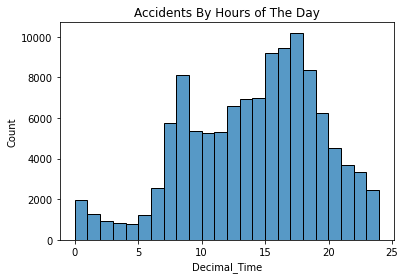

In [15]:
#significant hour accidents occur

sns.histplot(x = accidents['Decimal_Time'], bins = 24 )
plt.title('Accidents By Hours of The Day')


Majority of the accidents occur at (16,17,18,19). Although theres also a spike 9, building up from 8

Text(0.5, 1.0, 'Accidents By Day of The Week')

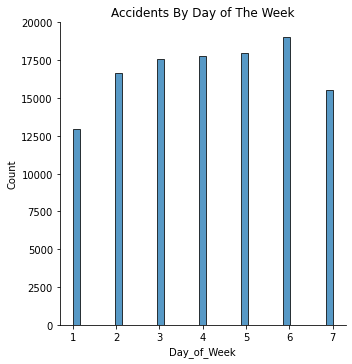

In [16]:
#Day of the week plot
sns.displot(x = accidents['Day_of_Week'] )
plt.title('Accidents By Day of The Week')

Accidents looks uniformly distributed through the days of the week.  Although the most occur on friday

Next cell checks the time accidents on friday occurs

Text(0.5, 1.0, 'Friday Accidents by Hours')

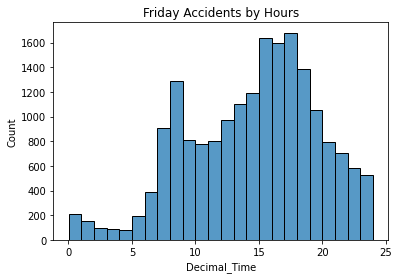

In [17]:
#Friday accident times
sns.histplot (accidents[accidents['Day_of_Week'] == 6]['Decimal_Time'], bins = 24)
plt.title ('Friday Accidents by Hours')

16,17,18

Significant hours and days of the week for motorbike accidents

In [18]:
#Check for the vehicle type motorbikes belongs to
vehicles['Vehicle_Type'].unique()

array([ 9,  1,  8, 19,  4,  3, 11,  5,  2, 10, 22, 97, 23, 21, 90, 98, -1,
       20, 16, 17, 18], dtype=int64)

1	Pedal cycle

2	Motorcycle 50cc and under

3	Motorcycle 125cc and under

4	Motorcycle over 125cc and up to 500cc

5	Motorcycle over 500cc

8	Taxi/Private hire car

9	Car

10	Minibus (8 - 16 passenger seats)

11	Bus or coach (17 or more pass seats)

16	Ridden horse

17	Agricultural vehicle

18	Tram

19	Van / Goods 3.5 tonnes mgw or under

20	Goods over 3.5t. and under 7.5t

21	Goods 7.5 tonnes mgw and over

22	Mobility scooter

23	Electric motorcycle

90	Other vehicle

97	Motorcycle - unknown cc

98	Goods vehicle - unknown weight

-1	Data missing or out of range

2, 3, 4, 5, 23, 97 represent motocycles.

A new column will be created. This column will classsify motorbikes as 1, and other vehicle types as 0


In [19]:
#Function to group motocycles and non-motorcycles
def Motorcycle_column (data):
    if data['Vehicle_Type']==2 or data['Vehicle_Type']==3 or data['Vehicle_Type']==4 or data['Vehicle_Type']==5 or data['Vehicle_Type']==97 or data['Vehicle_Type']==23:
        return 1
    
    else:
        return 0
vehicles['Motorcycle'] = vehicles.apply(Motorcycle_column, axis = 1)

Another function will also be created to put the vehicles age into an age band

In [20]:
#To group the age of vehicles into age band
def Vehicle_Age_Band (data):
    if data [ 'Age_of_Vehicle'] <= 0:
        
         return  -1
        
    elif( data [ 'Age_of_Vehicle'] > 0) and ( data [ 'Age_of_Vehicle']  <= 5):
        return 1
        
    elif (data [ 'Age_of_Vehicle']  > 5) and ( data [ 'Age_of_Vehicle'] <= 10 ):
        return 2
        
    elif (data [ 'Age_of_Vehicle']  > 10) and (data [ 'Age_of_Vehicle']  <= 15 ):
        return 3
        
    elif (data [ 'Age_of_Vehicle'] > 15) and ( data [ 'Age_of_Vehicle']  <= 20 ):
        return 4
        
    elif (data [ 'Age_of_Vehicle'] > 20) and ( data [ 'Age_of_Vehicle']  <= 25 ):
        return 5
        
    elif( data [ 'Age_of_Vehicle'] > 25) and ( data [ 'Age_of_Vehicle']  <= 35 ):
        return 6
        
    elif (data [ 'Age_of_Vehicle']  > 35) and (data [ 'Age_of_Vehicle']  <= 45 ):
        return 7
        
    elif (data [ 'Age_of_Vehicle']  > 45) and ( data [ 'Age_of_Vehicle']  <= 55 ):
        return 8
        
    elif (data [ 'Age_of_Vehicle']  > 55)and ( data [ 'Age_of_Vehicle']  <= 65 ):
        return 9
        
    elif (data [ 'Age_of_Vehicle']  > 65) and ( data [ 'Age_of_Vehicle']  <= 75 ):
        return 10
        
    elif  data [ 'Age_of_Vehicle']  > 75:
        return 11
vehicles['Vehicle_Age_Band'] = vehicles.apply(Vehicle_Age_Band, axis = 1)
vehicles['Vehicle_Age_Band'] = vehicles['Vehicle_Age_Band'].astype('int')

merge Accident, Vehicles and casualties dataset

In [21]:
#Convert Accident Index to string. This will help when merging the datasets
accidents['Accident_Index'] = accidents['Accident_Index'].astype(str)
casualties['Accident_Index'] = casualties['Accident_Index'].astype(str)
vehicles['Accident_Index'] = vehicles['Accident_Index'].astype(str)

In [22]:
#Merge the three datasets
accidents_vehicles = accidents.merge(vehicles, on = 'Accident_Index')
accidents_vehicles_casualties = accidents_vehicles.merge(casualties, on = ['Vehicle_Reference','Accident_Index'])

Text(0.5, 1.0, 'Motorbike Accidents by Hour of the Day')

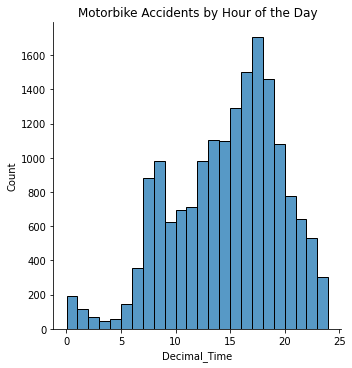

In [23]:
#plot of accident times for motorcycle related accidents

sns.displot ( accidents_vehicles [ accidents_vehicles['Motorcycle'] == 1]['Decimal_Time'], bins = 24)
plt.title ('Motorbike Accidents by Hour of the Day')

morning accident rise at 8,9 

evening accidents from 13, 16,17,18,19.. peaking at 18

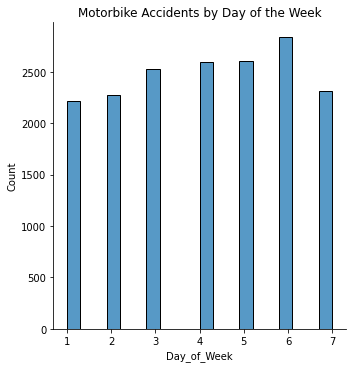

In [24]:
#plot of days of the week for motrocycle accident

sns.displot ( accidents_vehicles [ accidents_vehicles['Motorcycle'] == 1]['Day_of_Week'])
plt.title ('Motorbike Accidents by Day of the Week')
plt.show()

shows thesame pattern with the accident data.

In [25]:
accidents_vehicles_casualties['Casualty_Class'].unique()

array([1, 2, 3], dtype=int64)

the casualty class 3 represents pedestrians

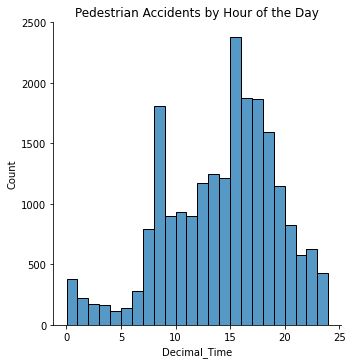

In [26]:
#pedestrian plot from the accidents_vehicles_casualties dataset
sns.displot(accidents_vehicles_casualties [accidents_vehicles_casualties ['Casualty_Class'] == 3]['Decimal_Time'], bins = 24 )

plt.title ('Pedestrian Accidents by Hour of the Day')
plt.show()

9, 16 17, 18.. peak at 16

Text(0.5, 1.0, 'Pedestrian Accidents by Day of the Week')

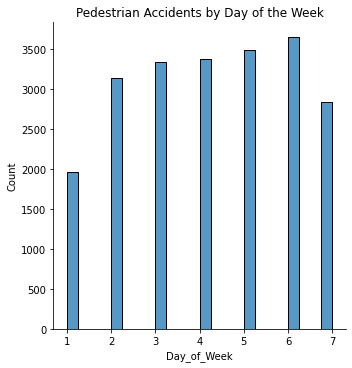

In [27]:
sns.displot(accidents_vehicles_casualties [accidents_vehicles_casualties ['Casualty_Class'] == 3]['Day_of_Week'], bins = 24 )

plt.title ('Pedestrian Accidents by Day of the Week')

pedestrian accident is lowest on sunday, increases steadily from monday and peaks on friday.

Effect of daylight savings on accidemt

2019 daylight saving period was between Sunday, 31 March 2019 to Sunday, 27 October 2019. https://www.timeanddate.com/time/change/uk/london?year=2019

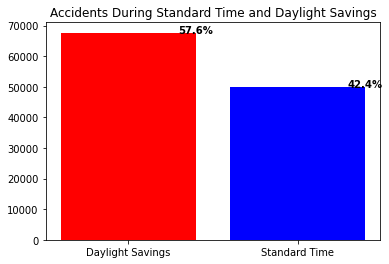

In [28]:
#Group the accident data into standard and daylight savings time and also show by plot their contribution to the total accidents
daylight_begins = '2019-03-31'
daylight_ends = '2019-10-27'

daylight_time = accidents[(accidents['Date_time'] >= daylight_begins) & (accidents['Date_time'] <= daylight_ends)]

#for dates not in day_light saving date
standard_time = accidents [~accidents['Date_time'].isin(daylight_time['Date_time'])]

ax = plt.bar(x = ['Daylight Savings', 'Standard Time'], height= [len(daylight_time), len(standard_time)], color =['red', 'blue'])

plt.title ('Accidents During Standard Time and Daylight Savings')

for bar in ax.patches:
    percentage = '{:.1f}%'.format(100 * bar.get_height()/len(accidents))
    x = bar.get_x() + bar.get_width()
    y = bar.get_height()
    plt.annotate(percentage, (x, y), ha='center', weight = 'bold')
    

more accidents (57.6%) occured during daylight savings, compared to standard time (42.4%)

For the week before and after daylight savings starts

since daylight saving starts on 31/03/2019, and

ends on 27/10/2019

The Accident data will be filtered based on these conditions and the corresponding weeks will be obtained

In [29]:
print ( '2019 day light starts on Week', accidents[ ( accidents['Date'] == '31/03/2019')] ['Week_of_the_year'].head(1).values )

print ('2019 day light ends  on Week', accidents[  ( accidents['Date'] == '27/10/2019') ] [ 'Week_of_the_year'].head(1).values)

2019 day light starts on Week [13]
2019 day light ends  on Week [43]


In [30]:
#create a data subset data of the week after daylight starts and stops
week_after_daylight_start = accidents[ accidents['Week_of_the_year'] == 14 ]

week_after_daylight_stops = accidents[  accidents['Week_of_the_year'] == 44 ]

the next plot shows accidents by week, displaying only the results for week 14 and 44.

the code to do this was from https://stackoverflow.com/questions/63603222/adding-percentages-to-sns-countplot-how-do-i-show-percentages-for-two-values-w and modified for this purpose



Text(0.5, 1.0, 'Plot of Accidents by Week of The Year')

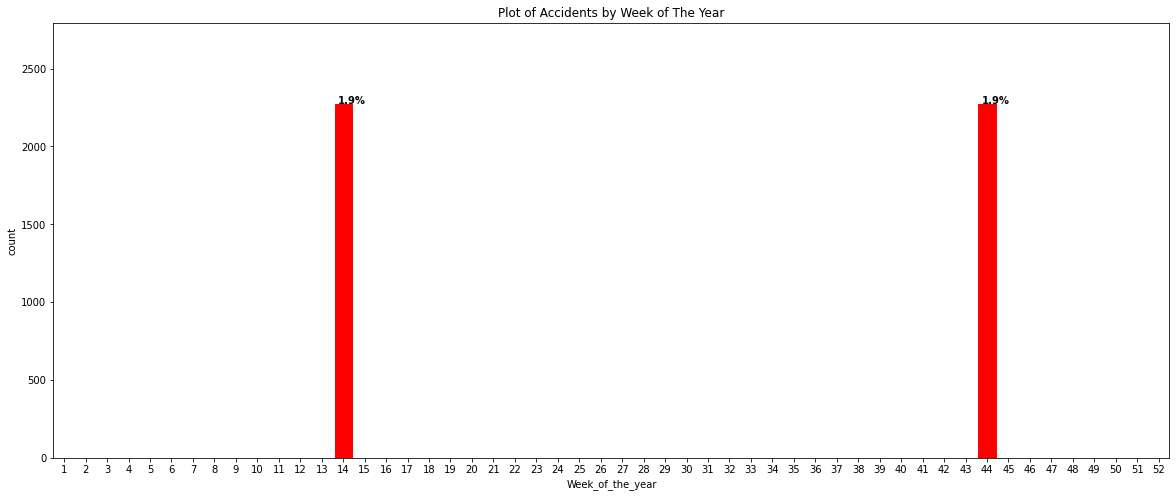

In [31]:
#Plot to display figures from only week 14 and 44
plt.figure(figsize=  (20,8))

ax = sns.countplot(x = accidents['Week_of_the_year']  )

for bar in ax.patches:
    if ( (bar.get_height() == len(week_after_daylight_start)) or (bar.get_height() == len(week_after_daylight_stops) )):
        
        bar.set_color('red')
        percentage = '{:.1f}%'.format(100 * bar.get_height()/len(accidents))
        x = bar.get_x() + bar.get_width()
        y = bar.get_height()
        
        
        ax.annotate(percentage, (x, y), ha='center', weight = 'bold')
    
    else:
        bar.set_color('white')
plt.title ('Plot of Accidents by Week of The Year')


accident rate for both weeks were 19%

Next plot checks the accident severity of the two weeks

Text(0.5, 1.0, 'Accident Severity of Week After Daylight Saving Stoppped')

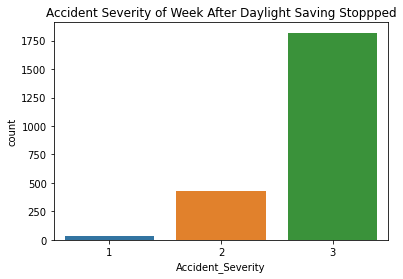

In [32]:
sns.countplot (x= week_after_daylight_stops['Accident_Severity'])

plt.title ('Accident Severity of Week After Daylight Saving Stoppped')

Text(0.5, 1.0, 'Accident Severity of Week After Daylight Saving Start')

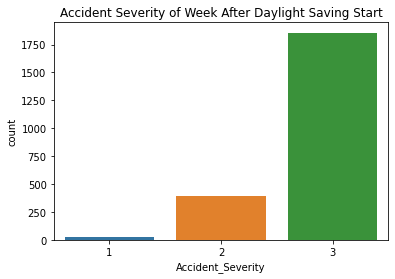

In [33]:
sns.countplot (x = week_after_daylight_start['Accident_Severity'])

plt.title ('Accident Severity of Week After Daylight Saving Start')

for both weeks, there were more accidents with slight severity and few fatal accidents


How Sunrise and Sunset affects the accidents

the average time for UK sunrise and sunset in 2019 is given below:

sunrise time, between 6am and 10am

sunset time between 5pm and 7pm
https://www.sunrise-and-sunset.com/en/sun/russia/uk/2019. 

In [34]:
#Filter accident data on sunrise and sunset
sunrise_accidents = accidents [(accidents['Decimal_Time'] >= 6.0) & (accidents['Decimal_Time']<=10.0) ]
sunset_accidents = accidents [ (accidents['Decimal_Time'] >= 17.0) & (accidents['Decimal_Time']<=19.0)   ]

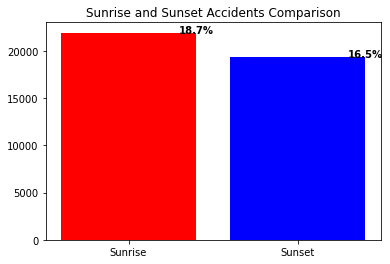

In [35]:
ax = plt.bar(x = ['Sunrise', 'Sunset'], height= [len(sunrise_accidents), len(sunset_accidents)], color =['red', 'blue'])

plt.title ('Sunrise and Sunset Accidents Comparison')

for bar in ax.patches:
    percentage = '{:.1f}%'.format(100 * bar.get_height()/len(accidents))
    x = bar.get_x() + bar.get_width()
    y = bar.get_height()
    plt.annotate(percentage, (x, y), ha='center', weight = 'bold')

18.7% of the total accidents occur during sunrise, 16.5% occur during sunset. the remaining 64.8% is distributed across other times of the day

Text(0.5, 1.0, 'Accident Severity During Sunrise')

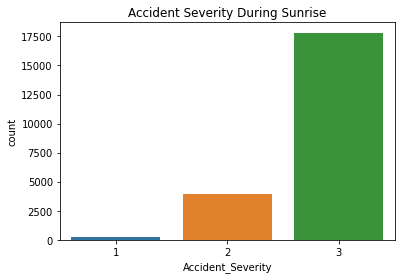

In [36]:
sns.countplot(x = sunrise_accidents['Accident_Severity'])

plt.title ('Accident Severity During Sunrise')

Text(0.5, 1.0, 'Accident Severity During Sunset')

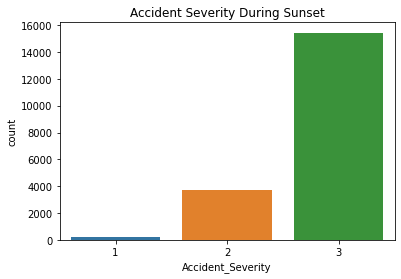

In [37]:
sns.countplot(x = sunset_accidents['Accident_Severity'])
plt.title ('Accident Severity During Sunset')

For Age of Vehicle

Text(0.5, 1.0, 'Accident By Age of Vehicles')

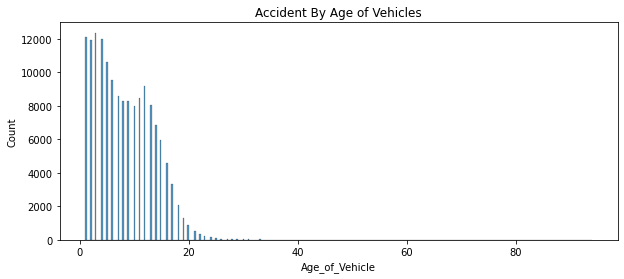

In [38]:
vehicle_age =   vehicles [vehicles['Age_of_Vehicle'] > 0]
plt.figure (figsize= ( 10, 4 ))

sns.histplot (x = vehicle_age['Age_of_Vehicle'])

plt.title ('Accident By Age of Vehicles')

The older the vehicle type, the less likely it is to get into an accident

Text(0.5, 1.0, 'Accidents By Vehicle Type')

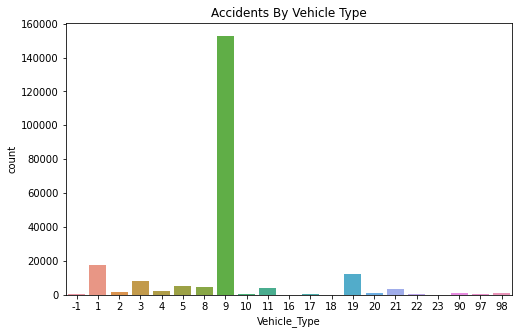

In [39]:
#Plot od Accident by vehicle type
plt.figure(figsize=(8,5))
sns.countplot (x =vehicles['Vehicle_Type'])
plt.title ('Accidents By Vehicle Type')

cars are involved in more accidents than other vehicle types. 70% of all accidents

Text(0.5, 1.0, 'Box Plot of Engine Capacity')

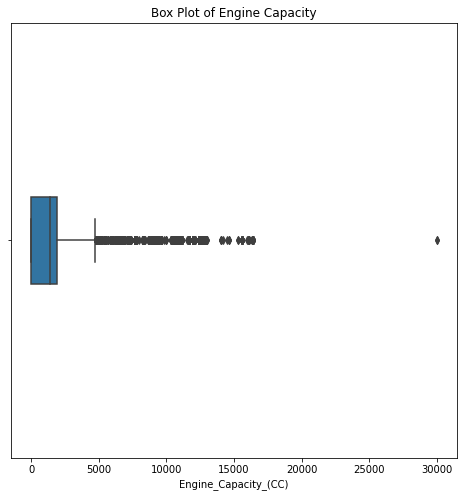

In [40]:
plt.figure(figsize=(8, 8))
sns.boxplot (x =vehicles['Engine_Capacity_(CC)'], width= 0.2)
plt.title ('Box Plot of Engine Capacity')



There appears an outlier at 30,000cc engine capacity

In [41]:
#check out the outliers in the plot
vehicles [vehicles['Engine_Capacity_(CC)'] > 20000]

,Accident_Index,Vehicle_Reference,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,Hit_Object_off_Carriageway,1st_Point_of_Impact,Was_Vehicle_Left_Hand_Drive?,Journey_Purpose_of_Driver,Sex_of_Driver,Age_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_IMD_Decile,Driver_Home_Area_Type,Vehicle_IMD_Decile,Motorcycle,Vehicle_Age_Band
84787,2019140895070,2,20,0,18,0,8,0,0,0,0,4,1,1,1,65,9,29980,2,14,9,1,9,0,3
123949,2019340S01041,3,20,0,18,0,8,0,0,0,0,1,1,1,1,56,9,29980,2,8,8,3,8,0,2


The two outlier points will be investigated further

In [42]:
#The accident information of the first oulier. it shows that two vehicles were incolved in the accident

accidents[accidents['Accident_Index'] == '2019140895070']

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,1st_Road_Number,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,Decimal_Time,Date_time,Week_of_the_year
46605,2019140895070,434398.0,387343.0,-1.484345,53.38184,14,2,2,2,04/11/2019,2,13:11,215,E08000019,3,57,1,30,1,4,3,61,0,0,1,2,2,0,0,1,1,13.18,2019-04-11 13:11:00,15


In [43]:
#check the other vehicle involved in the accident from the vehicles dataset
vehicles[vehicles['Accident_Index'] == '2019140895070']

,Accident_Index,Vehicle_Reference,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,Hit_Object_off_Carriageway,1st_Point_of_Impact,Was_Vehicle_Left_Hand_Drive?,Journey_Purpose_of_Driver,Sex_of_Driver,Age_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_IMD_Decile,Driver_Home_Area_Type,Vehicle_IMD_Decile,Motorcycle,Vehicle_Age_Band
84786,2019140895070,1,9,0,5,0,4,0,0,0,0,1,1,5,1,71,10,2736,1,16,1,1,1,0,4
84787,2019140895070,2,20,0,18,0,8,0,0,0,0,4,1,1,1,65,9,29980,2,14,9,1,9,0,3


In [44]:
#Repeat the same process of the first oulier on the second outlier

accidents[accidents['Accident_Index'] == '2019340S01041']

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,1st_Road_Number,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,Decimal_Time,Date_time,Week_of_the_year
67808,2019340S01041,478021.0,242111.0,-0.863092,52.071892,34,3,3,1,25/03/2019,2,09:40,385,E10000021,3,508,6,60,3,4,5,79,0,0,1,1,1,0,0,2,1,9.67,2019-03-25 09:40:00,13


In [45]:
accidents[accidents['Accident_Index'] == '2019340S01041']

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,1st_Road_Number,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,Decimal_Time,Date_time,Week_of_the_year
67808,2019340S01041,478021.0,242111.0,-0.863092,52.071892,34,3,3,1,25/03/2019,2,09:40,385,E10000021,3,508,6,60,3,4,5,79,0,0,1,1,1,0,0,2,1,9.67,2019-03-25 09:40:00,13


smaller engine cars are more prone to accident. cars with less than 5000cc engine capacity have the most accident occurence. which aligns with vehicle type 9 (cars) having the most accidents.

the two greater than 20000cc engine capacity were also involved in accident with the smaller engine capacity cars.

For Weather condition

Text(0.5, 1.0, 'Accidents by Weather condition')

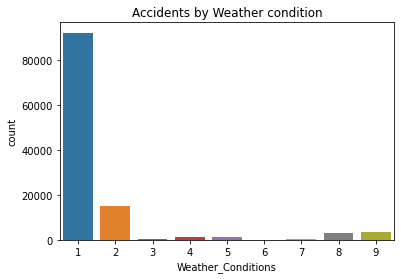

In [46]:
sns.countplot(x = accidents['Weather_Conditions'])

plt.title ('Accidents by Weather condition')


suprisingly, more accidents occur during fine weather, compared to the other weather conditions, since more people tend to drive during fine weather condition

Text(0.5, 1.0, 'Accidents by Journey Purpose of Driver')

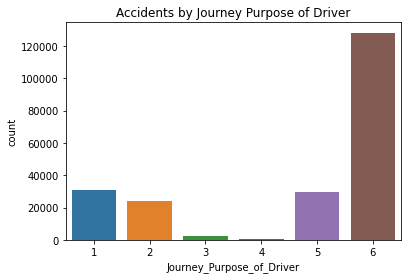

In [47]:
#Show Accidents by journey purpose of driver
journey_purpose = vehicles [vehicles['Journey_Purpose_of_Driver'] > 0]
sns.countplot(x = journey_purpose ['Journey_Purpose_of_Driver'])

plt.title ('Accidents by Journey Purpose of Driver')


not a lot can be learnt from here, since most of the accident ocur when the journey purpose is unknown. while the least occur for school related journeys 

Text(0.5, 1.0, 'Accident By Age Band of Driver')

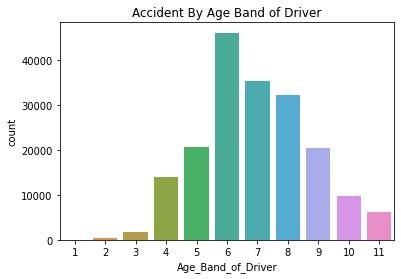

In [48]:
#Accidents by Age Band of Driver

age = vehicles [ vehicles['Age_Band_of_Driver'] > 0]

sns.countplot (x = age['Age_Band_of_Driver'] )
plt.title ('Accident By Age Band of Driver')



Drivers in the age range 26 - 35 are involved in more accidents

Text(0.5, 1.0, 'Accidents By Speed Limit')

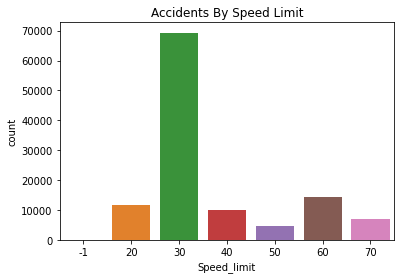

In [49]:
#Accident by Sppedlimit
sns.countplot(x = accidents['Speed_limit'])
plt.title ('Accidents By Speed Limit')


This also shows that more accidents occur at the 30mph dpeed zones, followed by 60mph

Association Rule Mining will be used in predicting conditions that might lead to an accident

The conditions that will be considered are as follows:

Accident Severity

Speed limit

Weather Conditions

Road Type

1st Road Class

Junction Detail

Light Conditions

Vehicle Type

Driver Age Band

Vehicle Age Band

Vehicle Manoeuvre

Junction Location

In [50]:
#Function to generate the accident rules
def accident_rules (df, min_support, confidence_threshold):
    dummy_df = pd.get_dummies (df, columns=df.columns )
    frequent = apriori(dummy_df, min_support= min_support, use_colnames= True)
    rules = association_rules (frequent, metric = 'confidence', min_threshold= confidence_threshold)
    return frequent, rules

In order to get the most reasonable conditions, minimun support of 0.4 and confidence threshold of 0.8 will be used

In [51]:
#set rule features and generate the rules
data= accidents_vehicles [[ 'Journey_Purpose_of_Driver', 'Vehicle_Type', 'Age_Band_of_Driver', 'Vehicle_Age_Band',
                           'Light_Conditions', 'Road_Type','Vehicle_Manoeuvre', 'Speed_limit', 
                           'Weather_Conditions','1st_Road_Class', 'Junction_Location','Accident_Severity' ]]

frequent_items, rules = accident_rules (data, min_support = 0.4, confidence_threshold= 0.8)

In [52]:
frequent_items

,support,itemsets
0,0.592746,(Journey_Purpose_of_Driver_6)
1,0.705635,(Vehicle_Type_9)
2,0.720183,(Light_Conditions_1)
3,0.712234,(Road_Type_6)
4,0.471788,(Vehicle_Manoeuvre_18)
5,0.577417,(Speed_limit_30)
6,0.791983,(Weather_Conditions_1)
7,0.458317,(1st_Road_Class_3)
8,0.409902,(Junction_Location_0)
9,0.798471,(Accident_Severity_3)


Frequent items of values greater than 0.5 will be considered here

In [53]:
frequent_items =  frequent_items[frequent_items['support'] > 0.5].sort_values (by = 'support', ascending= False)

Visualize the frequent items

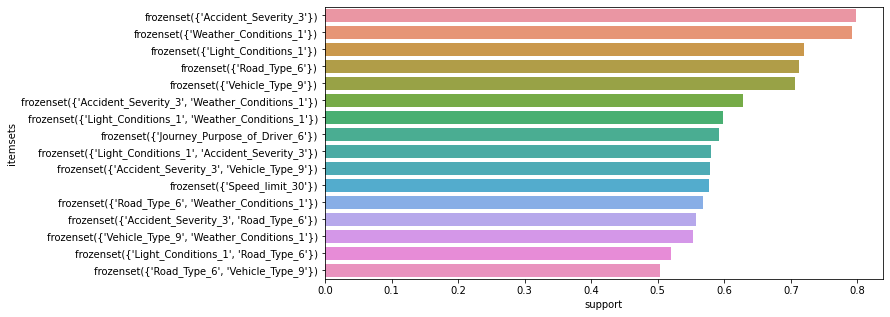

In [54]:
#plot of the frequent item sets
plt.figure(figsize= (10, 5))
sns.barplot (x = frequent_items['support'], y=frequent_items['itemsets'] )
plt.show()

The plot shows conditions where most accidents occur with fine weather and day light on top of the list

In [55]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Journey_Purpose_of_Driver_6),(Accident_Severity_3),0.592746,0.798471,0.482963,0.814789,1.020436,0.009672,1.088103
1,(Vehicle_Type_9),(Accident_Severity_3),0.705635,0.798471,0.578429,0.819728,1.026622,0.015000,1.117915
2,(Light_Conditions_1),(Weather_Conditions_1),0.720183,0.791983,0.597968,0.830300,1.048382,0.027596,1.225796
3,(Light_Conditions_1),(Accident_Severity_3),0.720183,0.798471,0.580490,0.806031,1.009468,0.005444,1.038973
4,(Speed_limit_30),(Road_Type_6),0.577417,0.712234,0.462171,0.800411,1.123803,0.050915,1.441794
5,(Speed_limit_30),(Accident_Severity_3),0.577417,0.798471,0.472435,0.818188,1.024693,0.011385,1.108444
6,"(Light_Conditions_1, Vehicle_Type_9)",(Weather_Conditions_1),0.496920,0.791983,0.409749,0.824579,1.041158,0.016198,1.185816
7,"(Light_Conditions_1, Vehicle_Type_9)",(Accident_Severity_3),0.496920,0.798471,0.412966,0.831052,1.040804,0.016190,1.192843
8,"(Road_Type_6, Vehicle_Type_9)",(Accident_Severity_3),0.503348,0.798471,0.405244,0.805096,1.008296,0.003334,1.033988
9,"(Vehicle_Type_9, Weather_Conditions_1)",(Accident_Severity_3),0.553482,0.798471,0.452526,0.817598,1.023954,0.010586,1.104861


31 rules in total were generated, considering rules with over 0.4 support

In [56]:
#filter rules with support greater than 40%
over_40_rules = rules[rules['support'] > 0.4]

In [57]:
over_40_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Journey_Purpose_of_Driver_6),(Accident_Severity_3),0.592746,0.798471,0.482963,0.814789,1.020436,0.009672,1.088103
1,(Vehicle_Type_9),(Accident_Severity_3),0.705635,0.798471,0.578429,0.819728,1.026622,0.015000,1.117915
2,(Light_Conditions_1),(Weather_Conditions_1),0.720183,0.791983,0.597968,0.830300,1.048382,0.027596,1.225796
3,(Light_Conditions_1),(Accident_Severity_3),0.720183,0.798471,0.580490,0.806031,1.009468,0.005444,1.038973
4,(Speed_limit_30),(Road_Type_6),0.577417,0.712234,0.462171,0.800411,1.123803,0.050915,1.441794
5,(Speed_limit_30),(Accident_Severity_3),0.577417,0.798471,0.472435,0.818188,1.024693,0.011385,1.108444
6,"(Light_Conditions_1, Vehicle_Type_9)",(Weather_Conditions_1),0.496920,0.791983,0.409749,0.824579,1.041158,0.016198,1.185816
7,"(Light_Conditions_1, Vehicle_Type_9)",(Accident_Severity_3),0.496920,0.798471,0.412966,0.831052,1.040804,0.016190,1.192843
8,"(Road_Type_6, Vehicle_Type_9)",(Accident_Severity_3),0.503348,0.798471,0.405244,0.805096,1.008296,0.003334,1.033988
9,"(Vehicle_Type_9, Weather_Conditions_1)",(Accident_Severity_3),0.553482,0.798471,0.452526,0.817598,1.023954,0.010586,1.104861


Next step is to visualize the rules generated from the data

All the visualization codes used were from https://github.com/Simmons-Wang/association-rule-mining-and-visualization/blob/main/src/ARM.ipynb

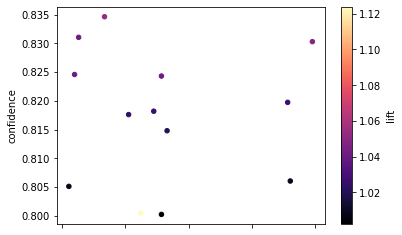

In [58]:
rules [['support', 'confidence', 'lift',]].plot.scatter(x= 'support', y = 'confidence', c = 'lift', colormap = 'magma')
plt.show()

the scatter plot shows that all the rules generated have lift values higher than 1 and generally have high confidence values

In [59]:
def draw_graph (rule, multiplier = 1000):
    
    g = nx.DiGraph()
    size_dict = {}
    color_dict = {}
    label_dict = {}
    for i in rule.index:
        ser = rule.loc[i]
        g.add_node(i)
        size_dict[i] = ser['support'] * multiplier
        color_dict[i] = ser['lift']
        label_dict[i] = ''
        for ant in list (ser['antecedents']):
            g.add_node(ant)
            g.add_edge(ant, i)
            size_dict[ant] = 0
            color_dict[ant] = 0
            label_dict [ant] = ant
        for j in list (ser['consequents']):
            g.add_node(j)
            size_dict[j] = 0
            color_dict[j] = 0
            label_dict[j] = j
            g.add_edge (i, j)
    node_list, size_list = zip (*size_dict.items())
    node_list, color_list = zip (*color_dict.items())
    plt.figure (figsize= (20, 10), dpi = 80)
    pos = nx.spring_layout (g)
    cmap = plt.cm.get_cmap('Reds')
    nx.draw_networkx_nodes(g, pos = pos, nodelist = node_list, node_size = size_list, node_color = color_list,
                          alpha = 0.5,  cmap = cmap)
    nx.draw_networkx_edges (g, pos = pos, edge_color = 'grey', alpha = 0.5, width = 2, arrowsize = 15)
    nx.draw_networkx_labels(g, pos = pos, labels = label_dict,  font_size = 20)
            
    plt.show()

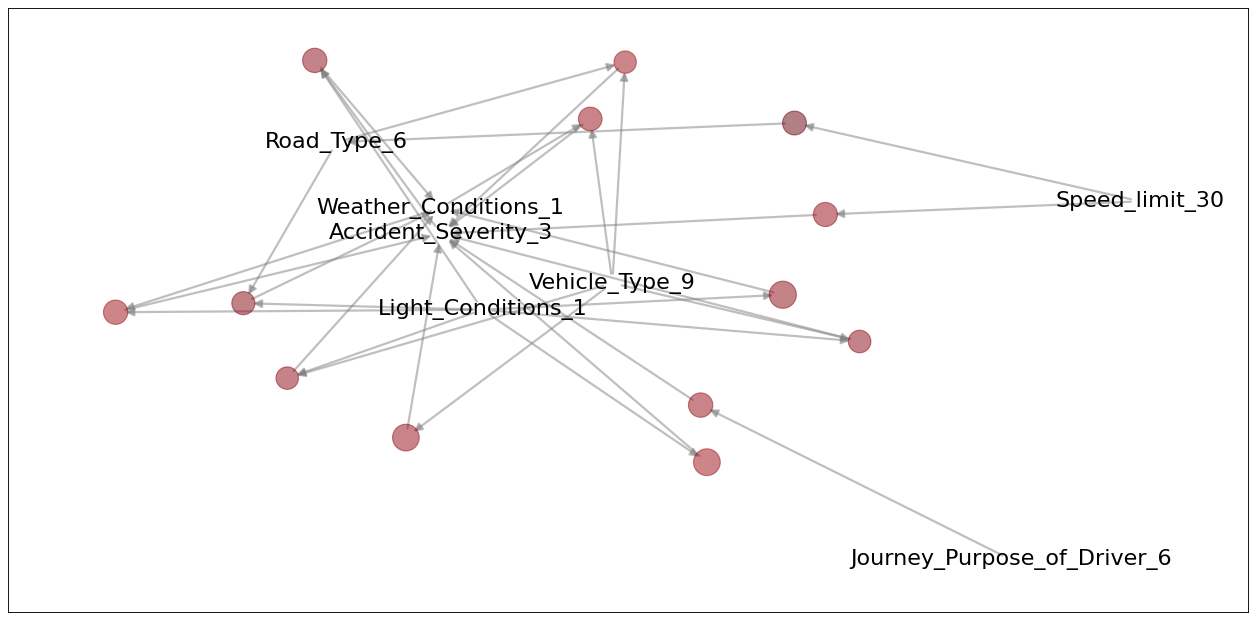

In [60]:
#plot of all the rules
draw_graph (rules, multiplier=1000)

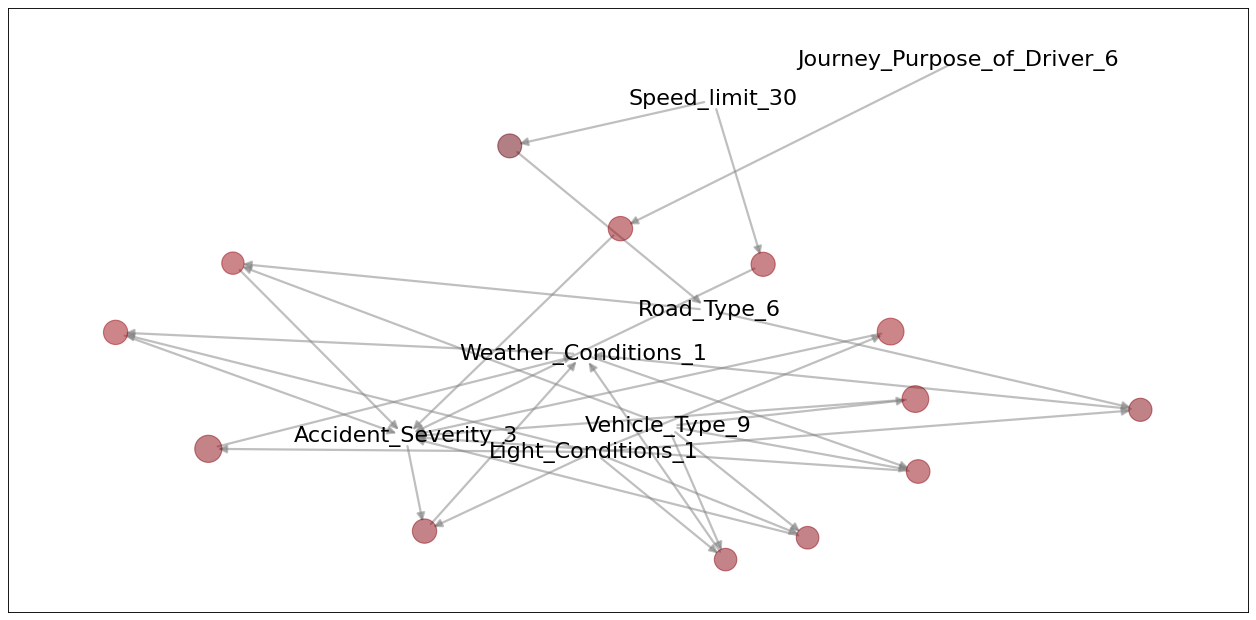

In [61]:
#plot of over 0.4 rules
draw_graph (over_40_rules, multiplier=1000)

For Geographical Location, clustering will be used to get the area with most accident

First the elbow curve will be used to get the best number of clusters to use

In [62]:
# Function to determine the best number of clusters
def Best_k_plot (data, max_cluster ):
    inertia  = []
    clusters = []
    for value in range (1, max_cluster):
        clusters.append(value)
        kmn = KMeans (n_clusters= value)
        kmn.fit(data)
        inertia.append(kmn.inertia_)
    sns.lineplot(clusters, inertia)

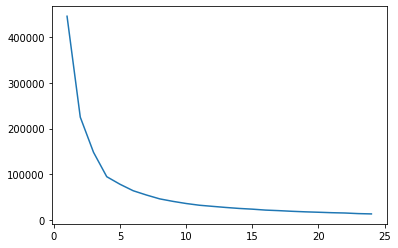

In [63]:
#Run the Best_K_Plot function on longitude and Latitude

clus_data_loc = accidents [['Longitude', 'Latitude']]
Best_k_plot (clus_data_loc, 25)

The best point on the curve appears somewhere close to 5

In [64]:
#for n_clustes = 5
kmn = KMeans(n_clusters =5)
kmn.fit(clus_data_loc)

KMeans(n_clusters=5)

Text(0.5, 1.0, 'Cluster Plot of Accidents By Geographical Location')

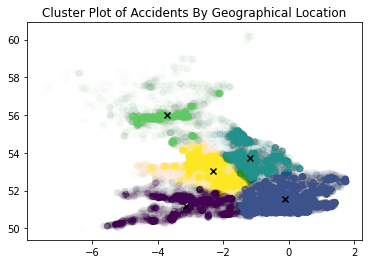

In [65]:
#dispaly the clusters on a plot

centers = kmn.cluster_centers_
plt.scatter(clus_data_loc['Longitude'], clus_data_loc['Latitude'], c = kmn.labels_ , alpha = 0.009 )

plt.scatter(centers[:,0], centers[:,1], marker="x", color='black')
plt.title ('Cluster Plot of Accidents By Geographical Location')

Using speed limit and weather conditions

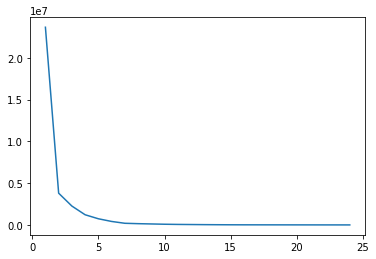

In [66]:
#Define the data and find the best number of clusters
cluster_speed_weather = accidents[['Speed_limit', 'Weather_Conditions']]
Best_k_plot (cluster_speed_weather, 25)

Text(0.5, 1.0, 'Weather and Speed Limit With 3 Clusters')

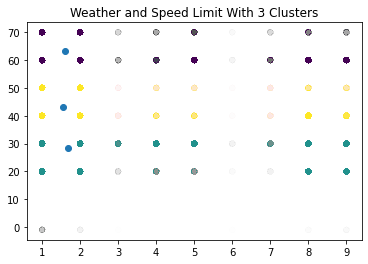

In [67]:
#With n_clusters = 3
kmc_speed_weather = KMeans(n_clusters= 3)
kmc_speed_weather.fit(cluster_speed_weather)

plt.scatter(  cluster_speed_weather['Weather_Conditions'], cluster_speed_weather['Speed_limit'] ,  c =kmc_speed_weather.labels_, alpha= 0.005)

plt.scatter(kmc_speed_weather.cluster_centers_[:,1], kmc_speed_weather.cluster_centers_[:,0])

plt.title ('Weather and Speed Limit With 3 Clusters')

Text(0.5, 1.0, 'Weather and Speed Limit With 6 Clusters')

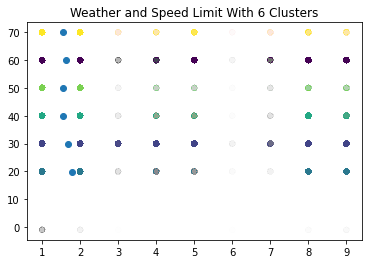

In [68]:
#using  n_clusters = 6
kmc_speed_weather = KMeans(n_clusters= 6)
kmc_speed_weather.fit(cluster_speed_weather)

plt.scatter( cluster_speed_weather['Weather_Conditions'], cluster_speed_weather['Speed_limit'],     c =kmc_speed_weather.labels_, alpha= 0.005)


plt.scatter(kmc_speed_weather.cluster_centers_[:,1], kmc_speed_weather.cluster_centers_[:,0])

plt.title ('Weather and Speed Limit With 6 Clusters')

Text(0.5, 1.0, 'Weather and Speed Limit With 12 Clusters')

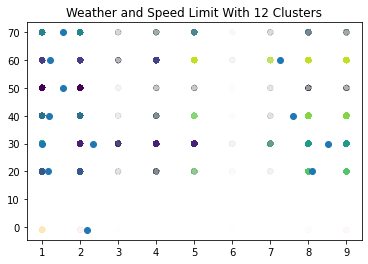

In [69]:
#With n_clusters = 12

kmc_speed_weather = KMeans(n_clusters= 12)
kmc_speed_weather.fit(cluster_speed_weather)

plt.scatter( cluster_speed_weather['Weather_Conditions'], cluster_speed_weather['Speed_limit'],     c =kmc_speed_weather.labels_, alpha= 0.005)


plt.scatter(kmc_speed_weather.cluster_centers_[:,1], kmc_speed_weather.cluster_centers_[:,0])

plt.title ('Weather and Speed Limit With 12 Clusters')

To view journey purpose and vehicle type in clusters

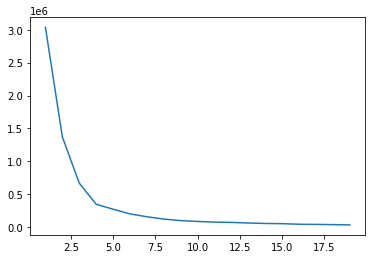

In [70]:
#Using the best_k_plot function
clus_data_driv = vehicles [['Age_Band_of_Driver', 'Journey_Purpose_of_Driver']]
Best_k_plot (clus_data_driv, 20)

Text(0.5, 1.0, 'Age Band and Jorney Purpose of Driver')

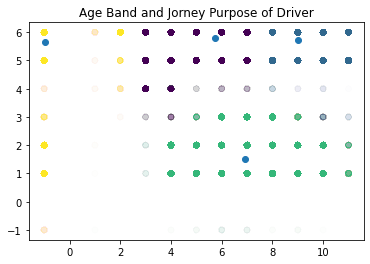

In [71]:
kmn = KMeans(n_clusters =4)
kmn.fit(clus_data_driv)



centers = kmn.cluster_centers_
plt.scatter(clus_data_driv['Age_Band_of_Driver'], clus_data_driv['Journey_Purpose_of_Driver'], c = kmn.labels_ , alpha = 0.009 )

plt.scatter(centers[:,0], centers[:,1] )

plt.title('Age Band and Jorney Purpose of Driver')


More cluster around age-band 6

# Build The Model to Predict Casualty Severity 

## Use PCA to determine the optimum number of features to use 

Using the accident_vehicles_casualties dataset to predict casualty severity.
In making the prediction, the Non-injurt based reporting system which classifies casualty severities into sligh and serious will be used (https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/922708/annex-update-severity-adjustments-methodology.pdf).

PCA will be used to determine the number of features that best explains the variance ratio of the data, then The selectKBest will be used for feature selection in making the predictions

To use f_classif function, the negative values needs to be dealtt with.

To do this, MinMax scaler will be used in scaling all values of the predictors between 0 and 5

The data will be standardized, so that there will be no bias among the features.


Only the numerical features will be used. The target will also be dropped. In this case, Accident_severity and Casualty_Severity will both be dropped

In [72]:
#instantiate MinMax scaler
minmax = MinMaxScaler(feature_range= (0,5))

In [73]:
X_features = accidents_vehicles_casualties.drop ( ['Accident_Index', 'Date_time', 'Date', 'Time',
                                                'Local_Authority_(Highway)', 'Casualty_Severity', 'Accident_Severity'] , axis = 1)

y = accidents_vehicles_casualties ['Casualty_Severity']

In [74]:
print ('Initial Size:', accidents_vehicles_casualties.shape)

print ('New Size:', X_features.shape)

Initial Size: (153158, 72)
New Size: (153158, 65)


Now, we have 65 features to work with. PCA will be applied on all the 65 features and the variance ratio will be visualized

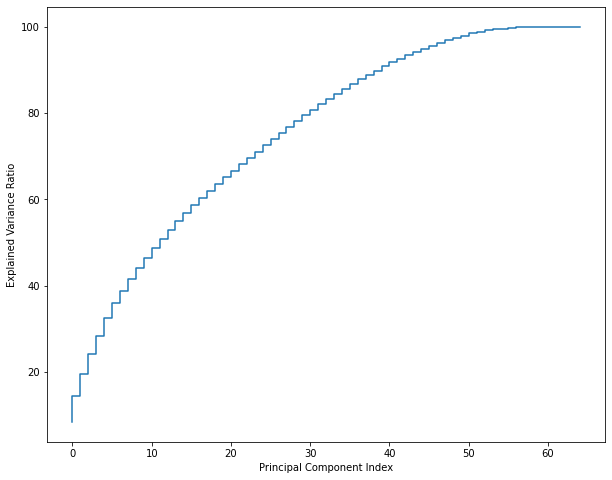

In [75]:
#Function to apply and Visualize PCA variance on the features

def PCA_variance (data):
    
    data = StandardScaler().fit_transform(data)
    pca = PCA(n_components = data.shape[1])
    data_pca = pca.fit_transform (data)
    var_ratio = np.round(pca.explained_variance_ratio_*100, decimals=2)
    values = np.cumsum (var_ratio)
    plt.figure( figsize= (10,8))
    plt.step(range(0,len(values)), values)
    plt.ylabel('Explained Variance Ratio')
    plt.xlabel('Principal Component Index')
    
PCA_variance (X_features)

The plot shows that eventhough there is no single feature that strongly predict the output label, over 80% variance of the data can be explained with 30 - 40 features

Even though the plot shows 40 features expalins a great percentage of the variance, the best features cab still be selected out of the 40. 

A defined number of features will be selected using the SelectKBest, and tested with a classsifier.

The classifier of choice here is the DecisionTree classifier

In [76]:
#function to check the features and compute the accuracy scores
#Xfeatures is the data
#target is the target label
#n is the number of features to select
def Feature_Selection (Xfeatures, target, n ):
  
    best = SelectKBest (score_func= f_classif, k = n)

    X_best = best.fit_transform ( Xfeatures, y)

    X_train_best, X_test_best, y_train_best, y_test_best = train_test_split(X_best, y, test_size=.30, random_state=1)
    
    dt_best = DecisionTreeClassifier(criterion= 'gini')

    dt_best.fit(X_train_best, y_train_best)
    
    y_pred_best = dt_best.predict(X_test_best)
    
    accuracy_best = round (dt_best.score(X_train_best, y_train_best)*100, 2)
    
    print('Training Accuracy for {} features is: {}' '\n'.format( n, accuracy_best))

    print (classification_report( y_pred_best, y_test_best))

In [77]:
#Shows the result of the number of features tested

best_n = [40, 30, 20, 15, 10, 7]

for values in best_n:
    
    Feature_Selection (X_features, y, values )

Training Accuracy for 40 features is: 99.96

              precision    recall  f1-score   support

           1       0.09      0.09      0.09       588
           2       0.31      0.29      0.30      8319
           3       0.84      0.85      0.85     37041

    accuracy                           0.74     45948
   macro avg       0.41      0.41      0.41     45948
weighted avg       0.73      0.74      0.74     45948

Training Accuracy for 30 features is: 99.96

              precision    recall  f1-score   support

           1       0.09      0.08      0.08       607
           2       0.30      0.28      0.29      8258
           3       0.84      0.85      0.84     37083

    accuracy                           0.74     45948
   macro avg       0.41      0.40      0.40     45948
weighted avg       0.73      0.74      0.73     45948

Training Accuracy for 20 features is: 99.93

              precision    recall  f1-score   support

           1       0.09      0.08      0.08     

With trainig accuracies of almost 100% and validation/test accuracies of between 73 - 74. the result of 40, 30 and 20 features show signs of overfitting on the training data

To build the model, the best 10 to 15 features, which produced training and validation accuracies wil be selected to work with

In [78]:
#Function to select and visualize best features for model prediction

def best_Features (X, y, predictors):
    
    selector = SelectKBest (f_classif, k = 'all' )

#Scale the features so as to take into account values that are less than 0    
    X_standardized = X.filter(predictors, axis = 1)
    X_standardized = minmax.fit_transform(X_standardized)
#put the scaled features in a dataframe
    X_standardized = pd.DataFrame( X_standardized, columns= predictors)

    selector.fit (X_standardized [predictors], y )
#Visualize the features    
    scores = -np.log10(selector.pvalues_)
    plt.bar(range(len(predictors)), scores)
    plt.xticks(range(len(predictors)), predictors, rotation='vertical')
    plt.show()

    

<AxesSubplot:>

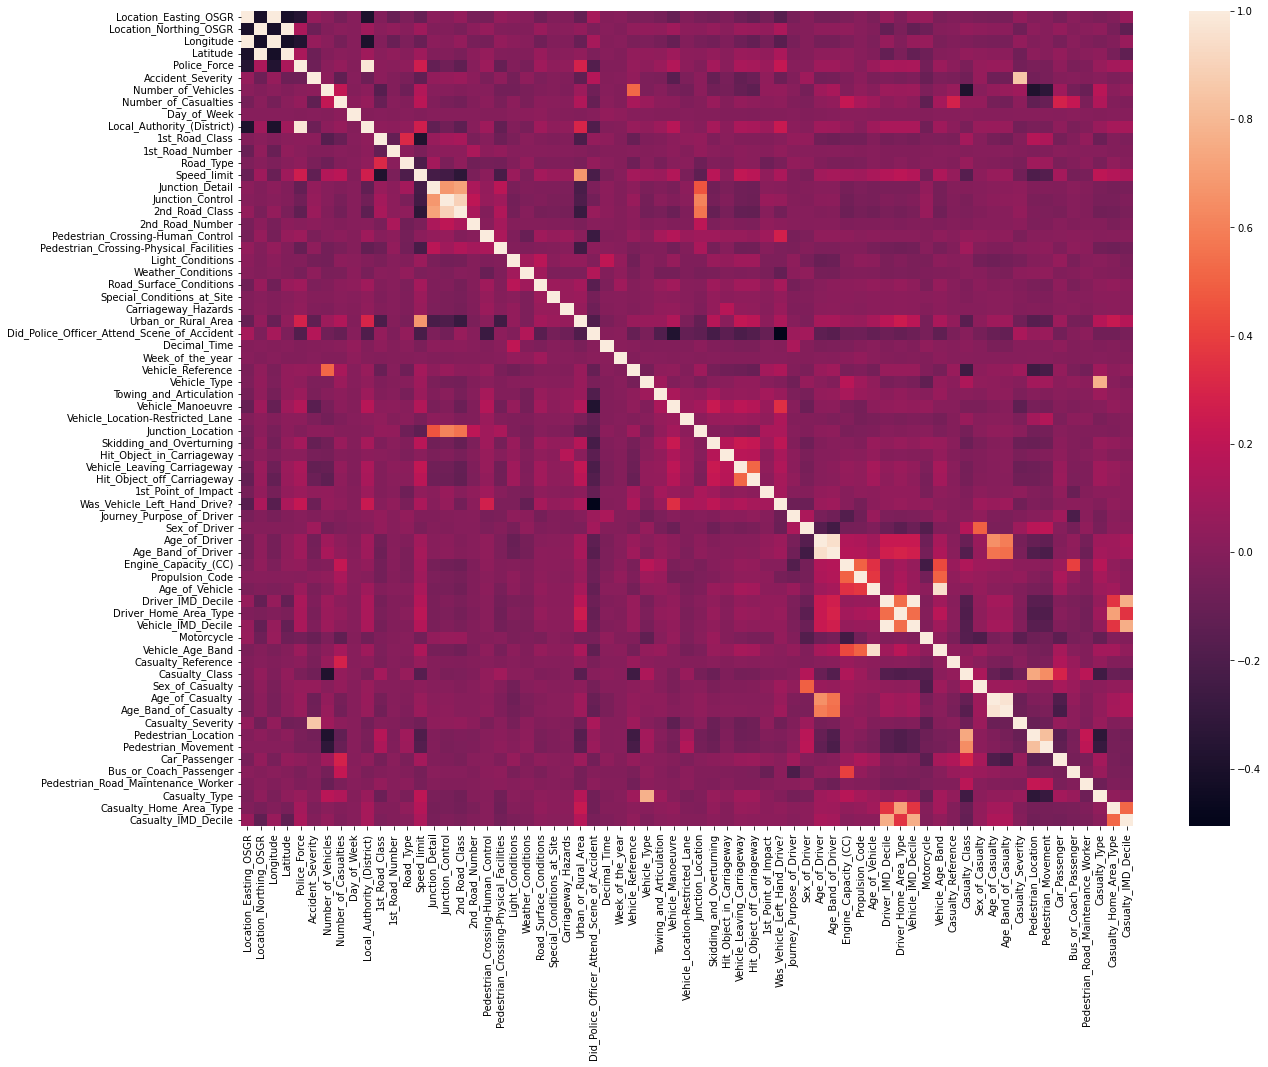

In [79]:
plt.figure(figsize=(20,15))

sns.heatmap (accidents_vehicles_casualties.corr())

Location_Easting_OSGR, Location_Northing_OSGR, Latitude, Longitude and Police_Force shows some level of correclation. 

Police_Force will therefore be chosen in place of the other features

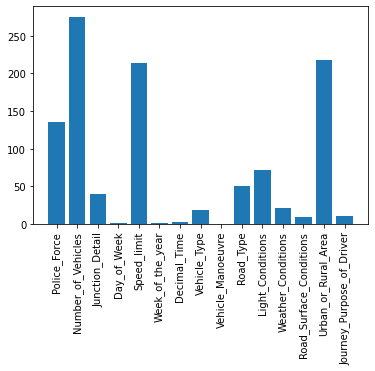

In [80]:
predictors = ['Police_Force','Number_of_Vehicles', 'Junction_Detail','Day_of_Week','Speed_limit', 'Week_of_the_year', 
              'Decimal_Time', 'Vehicle_Type', 'Vehicle_Manoeuvre', 'Road_Type', 'Light_Conditions', 'Weather_Conditions',
              'Road_Surface_Conditions', 'Urban_or_Rural_Area', 'Journey_Purpose_of_Driver']

best_Features(X_features, y, predictors)


The model prediction will be made on the non-injury based casualties (Slight and Serious)

in the quest for this, only the slight and serious injuries will be considered

In [81]:
#Function to extract only the slight and serious injuries
def drop_fatal (data):
    
    return data [data ['Casualty_Severity'] != 1]
    
non_injury = drop_fatal (accidents_vehicles_casualties)

In [82]:
#Convert target class to 1 and 0
#0 for slight
#1 for serious
def target_class (data):
    if data['Casualty_Severity']==2 :
        return 1
    else:
        return 0
non_injury ['Casualty_Severity'] = non_injury.apply(target_class, axis = 1)

In [83]:
#Assigning the target class
y_non_injury = non_injury['Casualty_Severity'] 
X_non_injury = non_injury.drop( ['Accident_Index', 'Date_time', 'Date', 'Time','Local_Authority_(Highway)', 
                                 'Casualty_Severity', 'Accident_Severity'] , axis = 1)


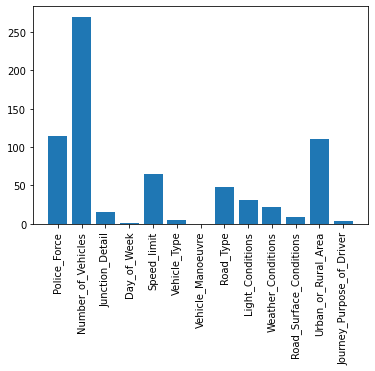

In [84]:
#Check for the best predictors for non-injury based accidents

predictors = ['Police_Force','Number_of_Vehicles', 'Junction_Detail', 'Day_of_Week','Speed_limit', 'Vehicle_Type', 
                         'Vehicle_Manoeuvre', 'Road_Type', 'Light_Conditions', 'Weather_Conditions',
                         'Road_Surface_Conditions', 'Urban_or_Rural_Area', 'Journey_Purpose_of_Driver']

best_Features(X_non_injury, y_non_injury, predictors)

The predictors show thesame level of strength for the injury based and non-injury based

By considering more features from the casualty dataset

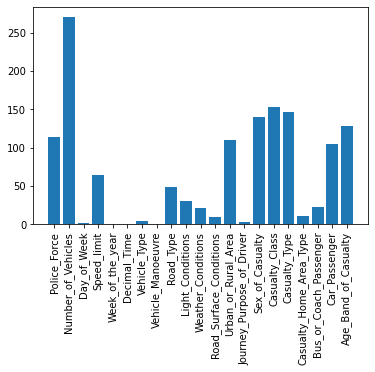

In [85]:
predictors = ['Police_Force', 'Number_of_Vehicles','Day_of_Week','Speed_limit', 'Week_of_the_year', 
              'Decimal_Time', 'Vehicle_Type', 'Vehicle_Manoeuvre', 'Road_Type', 'Light_Conditions', 'Weather_Conditions',
              'Road_Surface_Conditions', 'Urban_or_Rural_Area', 'Journey_Purpose_of_Driver', 'Sex_of_Casualty','Casualty_Class',
              'Casualty_Type', 'Casualty_Home_Area_Type', 'Bus_or_Coach_Passenger', 'Car_Passenger', 'Age_Band_of_Casualty']

best_Features(X_non_injury, y_non_injury, predictors)



The following features will be used ('Police_Force','Number_of_Vehicles', 'Vehicle_Type','Road_Type', 'Casualty_Class', 'Light_Conditions', 'Road_Surface_Conditions','Weather_Conditions', 'Casualty_Type', 'Bus_or_Coach_Passenger', 'Casualty_Home_Area_Type', 'Day_of_Week')


In [86]:
model_cols = [ 'Police_Force','Number_of_Vehicles', 'Vehicle_Type','Road_Type', 'Casualty_Class', 'Light_Conditions', 
                 'Road_Surface_Conditions','Weather_Conditions', 'Casualty_Type', 'Bus_or_Coach_Passenger',
                  'Casualty_Home_Area_Type', 'Sex_of_Casualty', 'Age_Band_of_Casualty', 'Day_of_Week']

X = X_non_injury.filter((model_cols), axis = 1)

Create a Train Test Split of the features and class labels and train model

a function will be used for this purpose

In [87]:
def model_training (classifier, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    classifier.fit(X_train, y_train )
    pred = classifier.predict(X_test)
    train_acc = round (classifier.score(X_train, y_train  ) *100, 2 )
    test_acc = round (classifier.score(X_test, y_test  ) *100, 2 )
    class_report = classification_report( pred, y_test)
    
    return train_acc, test_acc, class_report

In [88]:
dtree_train_acc, dtree_test_acc, dtree_classification_report = model_training (DecisionTreeClassifier(criterion= 'gini'),
                                                                              X, y_non_injury)

In [89]:
print ('Decision Tree Training Accuracy:', dtree_train_acc)
print(dtree_classification_report)

Decision Tree Training Accuracy: 97.11
              precision    recall  f1-score   support

           0       0.85      0.85      0.85     37885
           1       0.26      0.27      0.26      7537

    accuracy                           0.75     45422
   macro avg       0.55      0.56      0.56     45422
weighted avg       0.75      0.75      0.75     45422



The model produced a good training accuracy score, but very bad in precison and recall. which measures how well the model classifies the output labels.

To address this, the data will be balanced using the smote function

In [90]:
#To balance the data
def balance_data (X, y):
    
    sm = SMOTE(random_state = 1)

    sampled_X, sampled_y = sm.fit_resample(X, y)
    
    return sampled_X, sampled_y

X_res, y_res = balance_data (X, y_non_injury)

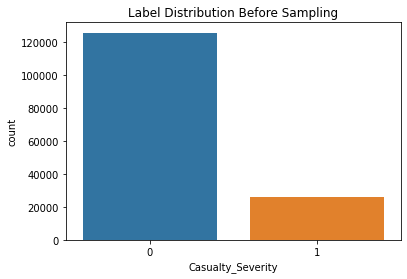

In [91]:
plt.title('Label Distribution Before Sampling')
sns.countplot (y_non_injury)
plt.show()

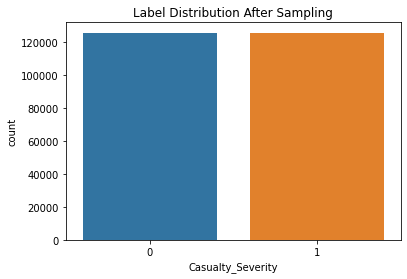

In [92]:
plt.title('Label Distribution After Sampling')
sns.countplot (y_res)
plt.show()

Perform a train test split on the sampled data

The data will now be trained with:

        Decision Tree
        Random Forest
        Logistic regression
        Gausian Naive Bayes
        Knearest Neighbor

In [93]:
#For Decision Tree
res_dtree_train_acc, res_dtree_test_acc, res_dtree_classification_report = model_training (DecisionTreeClassifier(criterion= 'gini'),
                                                                              X_res, y_res)

In [94]:
print ('Decision Tree Training Accuracy For Resampled Data:', res_dtree_train_acc)
print(res_dtree_classification_report)

Decision Tree Training Accuracy For Resampled Data: 94.94
              precision    recall  f1-score   support

           0       0.73      0.79      0.76     35058
           1       0.81      0.75      0.78     40219

    accuracy                           0.77     75277
   macro avg       0.77      0.77      0.77     75277
weighted avg       0.77      0.77      0.77     75277



In [95]:
#For Random Forest
rf_train_acc, rf_test_acc, rf_classification_report = model_training (RandomForestClassifier(), X_res, y_res)

In [96]:
print ('Random Forest Training Accuracy:', rf_train_acc)
print(rf_classification_report)

Random Forest Training Accuracy: 94.94
              precision    recall  f1-score   support

           0       0.78      0.82      0.80     35727
           1       0.83      0.79      0.81     39550

    accuracy                           0.81     75277
   macro avg       0.81      0.81      0.81     75277
weighted avg       0.81      0.81      0.81     75277



In [97]:
#Gausian NB
gnb_train_acc, gnb_test_acc, gnb_classification_report = model_training (GaussianNB(), X_res, y_res)

In [98]:
print ('Gaussian Naive Bayes Training Accuracy:', gnb_train_acc)
print(gnb_classification_report)

Gaussian Naive Bayes Training Accuracy: 64.66
              precision    recall  f1-score   support

           0       0.58      0.68      0.62     32337
           1       0.72      0.63      0.67     42940

    accuracy                           0.65     75277
   macro avg       0.65      0.65      0.65     75277
weighted avg       0.66      0.65      0.65     75277



In [99]:
#Logistic Regression
lr_train_acc, lr_test_acc, lr_classification_report = model_training (LogisticRegression(), X_res, y_res)

In [100]:
print ('Logistic regression Training Accuracy:', lr_train_acc)
print(lr_classification_report)

Logistic regression Training Accuracy: 65.39
              precision    recall  f1-score   support

           0       0.60      0.67      0.64     33705
           1       0.71      0.64      0.67     41572

    accuracy                           0.65     75277
   macro avg       0.65      0.66      0.65     75277
weighted avg       0.66      0.65      0.65     75277



In [101]:
#KNN
knn_train_acc, knn_test_acc, knn_classification_report = model_training (KNeighborsClassifier(n_neighbors=1), X_res, y_res)

In [102]:
print ('KNN Training Accuracy:', knn_train_acc)
print(knn_classification_report)

KNN Training Accuracy: 93.42
              precision    recall  f1-score   support

           0       0.71      0.83      0.77     32476
           1       0.85      0.75      0.80     42801

    accuracy                           0.78     75277
   macro avg       0.78      0.79      0.78     75277
weighted avg       0.79      0.78      0.78     75277



To visualize the performance of the models

In [103]:
#The accuracies achieved across all models will be put in a dataframe

model_accuracy = {'Model':['Decision_Tree','Random_Forest','Gausian_Naive_Bayes','Logistic_Regression','K_Nearest_Means'], 
            
            'Train_Accuracy(%)':[res_dtree_train_acc, rf_train_acc, gnb_train_acc, lr_train_acc, knn_train_acc],
                  
           'Test_Accuracy(%)':[res_dtree_test_acc, rf_test_acc, gnb_test_acc, lr_test_acc, knn_test_acc  ] }

model_accuracy = pd.DataFrame(model_accuracy)


In [104]:
model_accuracy

,Model,Train_Accuracy(%),Test_Accuracy(%)
0,Decision_Tree,94.94,76.92
1,Random_Forest,94.94,80.51
2,Gausian_Naive_Bayes,64.66,64.76
3,Logistic_Regression,65.39,65.31
4,K_Nearest_Means,93.42,78.24


In [ ]:
sns.barplot (data = final_accuracy, x = 'Val/Test_Accuracy(%)', y = 'Model', )
plt.title ('Validation/Test Accuracy of Models Trained ')
plt.show()


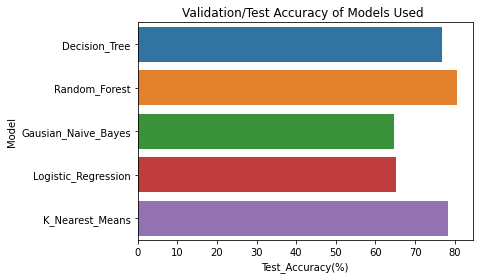

In [105]:
sns.barplot (data = model_accuracy, x = 'Test_Accuracy(%)', y = 'Model', )
plt.title ('Validation/Test Accuracy of Models Used ')
plt.show()


An ensemble Model will be trained by stacking the top 4 models

Model stacking will be used to try to improve the accuracies of the model predition.

Random forest, Decision tree and KNN will be used as the base models, while Logistic regression will be used as the meta-model for this approach

The code for stacking was from https://machinelearningmastery.com/blending-ensemble-machine-learning-with-python/

For model evaluation,  the K-Fold Cross-Validation will be used. using a 10-fold cross-validation on the data, using RepeatedStratified 3 times and mean classification accuracy and standard deviaton of each model

The same training and test dataset that has been resampled and used earlier will still be used

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=1)

In [107]:
def stacked_model ():
    #base models as level0
    level0 = list ()
    level0.append   (( 'dtree', DecisionTreeClassifier() )) 
    level0.append (( 'rfc', RandomForestClassifier() ))
    level0.append  (('knn', KNeighborsClassifier() ))
    level0.append (('lr', LogisticRegression())) 
    #Using lodisticRegression as the meta model
    level1 = LogisticRegression()
    model = StackingClassifier (estimators= level0, final_estimator= level1, cv = 5)

    return model

In [108]:
#List of Models to evaluate
def get_models():
    models = dict()
    models['dtree'] = DecisionTreeClassifier()
    models['rfc'] = RandomForestClassifier()
    models['knn'] = KNeighborsClassifier()
    models['lr'] = LogisticRegression()
    models['stacked'] = stacked_model()
    return models

In [109]:
#Function to evaluate the model performance
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores


In [110]:
models = get_models()
#Run and Evaluate the models.
results, names = list(), list()

for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))


>dtree 0.763 (0.003)
>rfc 0.799 (0.002)
>knn 0.762 (0.003)
>lr 0.654 (0.004)
>stacked 0.808 (0.003)


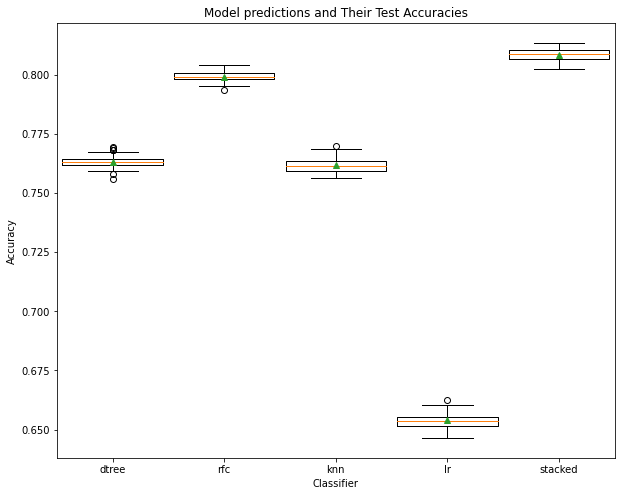

In [111]:
#Visualize the result
plt.figure(figsize= (10, 8))
plt.boxplot (results, labels = names, widths=0.9,  showmeans = True)
plt.title ('Model predictions and Their Test Accuracies')
plt.xlabel ('Classifier')
plt.ylabel ('Accuracy')
plt.show()

The stacked model, with a slightly better perfromance than random forest will now be used fro the final training and prediction

In [112]:
#Using the stacked model to train the full training data
level0 = list ()
level0.append (( 'dtree', DecisionTreeClassifier() )) 
level0.append (( 'rfc', RandomForestClassifier() ))
level0.append (('knn', KNeighborsClassifier() ))
level0.append (('lr', LogisticRegression())) 
level1 = LogisticRegression()
stacked_model = StackingClassifier (estimators= level0, final_estimator= level1, cv = 5)

stacked_model.fit (X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('dtree', DecisionTreeClassifier()),
                               ('rfc', RandomForestClassifier()),
                               ('knn', KNeighborsClassifier()),
                               ('lr', LogisticRegression())],
                   final_estimator=LogisticRegression())

In [113]:
model_pred = stacked_model.predict( X_test )

model_train_accuracy = round(stacked_model.score(X_train, y_train) * 100, 2)




In [114]:
#classification report and confusion matrix
model_clf_report =  classification_report ( model_pred, y_test)

conf_matrix = confusion_matrix (model_pred, y_test)


The heat map of the confusion matrix will be plotted. the code to plot was gotten from https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/ and modified


In [115]:
#Function to plot heatmap
def heat_map (confusion_matrix, title = 'title'):
    
    names = ['True Negative','False Positive','False Negative','True Positive']

    counts = ["{0:0.0f}".format(value) for value in confusion_matrix.flatten()]

    percentages = ["{0:.2%}".format(value) for value in confusion_matrix.flatten()/np.sum(confusion_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip( names, counts, percentages)]

    labels = np.array(labels).reshape(2,2)

    matrix_plot = sns.heatmap(confusion_matrix, annot=labels, fmt='')
    matrix_plot.set_title(title)
    matrix_plot.set_xlabel('Predicted')
    matrix_plot.set_ylabel('Actual')


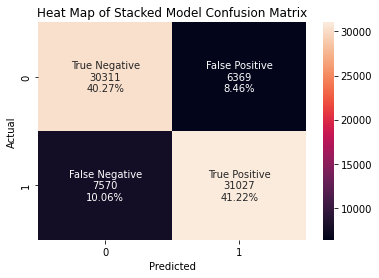

In [116]:
heat_map (conf_matrix, 'Heat Map of Stacked Model Confusion Matrix')

In [117]:
print ('Trainig Accuracy of Stacked model is:', model_train_accuracy, '\n' )


print (model_clf_report)


Trainig Accuracy of Stacked model is: 94.55 

              precision    recall  f1-score   support

           0       0.80      0.83      0.81     36680
           1       0.83      0.80      0.82     38597

    accuracy                           0.81     75277
   macro avg       0.81      0.82      0.81     75277
weighted avg       0.82      0.81      0.81     75277



In order to make performance comparison with the government model,  the probabilty of prediction will be made on the test data

The ROC-AUC curve will be used in comparing the performance of the two models

In [118]:
#Predict probability
model_pred_proba = stacked_model.predict_proba( X_test )

The result will be compared with the government model by using the 2019 accidents from the government model, and using their probabilities with the actual 2019 casualty severity

In [119]:
#2019 accidents from the government model
govt_model_2019 = govt_model [govt_model['accident_index'].str.startswith ('2019')]

In [120]:
len(govt_model_2019)

151406

In [121]:
#Extracting the data for government model comparison
y_govt_model = non_injury['Casualty_Severity']

govt_model_proba = np.array(govt_model_2019[[ 'Adjusted_Slight', 'Adjusted_Serious']])

In [122]:
#getting the true positive and false positive rates
govt_fpr, govt_tpr, _ = roc_curve (y_govt_model, govt_model_proba[:, 1] )

model_fpr, model_tpr, _ = roc_curve ( y_test, model_pred_proba [:, 1] )

In [123]:
govt_auc_score = np.round (roc_auc_score (y_govt_model, govt_model_proba[:, 1] ), 2)

In [124]:
model_auc_score = np.round ( roc_auc_score ( y_test, model_pred_proba [:, 1] ), 2)

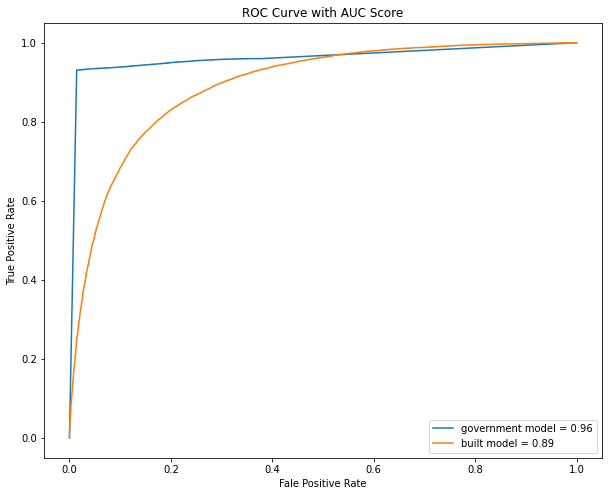

In [125]:
plt.figure (figsize= (10,8))
plt.plot ( govt_fpr, govt_tpr, label = 'government model = ' + str(govt_auc_score)  )
plt.plot ( model_fpr, model_tpr, label = 'built model = ' + str(model_auc_score)  )
plt.title ('ROC Curve with AUC Score')
plt.xlabel ('Fale Positive Rate')
plt.ylabel ('True Positive Rate')
plt.legend()
plt.show()

The plot shows that the best threshold for the models is around 0.5, where the Sensitivity (true positive rate) is the highest, and Specificity  (false negative rate) is lowest. Although, the government model is able to classify  more true positive cases, thereby, having a better true positive rate.